# Artificial Neural Networks Vs. Physics-Informed Neural networks

By David Ortiz and Rodrigo Salas, 2024 (ADD LICENSE!!!!!)

Read the seminal PINNs paper [here](https://www.sciencedirect.com/science/article/pii/S0021999118307125).

## Activity goals

By the end of this activity, you should be able to:

 - understand the need of numerical solution to complex models
 - understand the advantages of using Physics-Informed Neural Networks (PINNs) compared to common Artificial Neural Networks (ANN)
 - train data-driven PINNs using PyTorch
 - solve non-linear models using data-free PINNs (Leave as homework)

## Task overview

We will be coding a PINN from a scratch in PyTorch and using 

# Problem overview
We want to solve the mathematical problem related to the **oscillating pendulum**[(wiki)](https://en.wikipedia.org/wiki/Pendulum_(mechanics)):


| ![GIF](/home/ihealth/Dropbox/Trabajo/Proyectos/iHealth/Codes/ihealth-pinns-workshop/data/figures/Oscillating_pendulum.gif) | <img src="/home/ihealth/Dropbox/Trabajo/Proyectos/iHealth/Codes/ihealth-pinns-workshop/data/figures/Pendulum_gravity.svg" alt="Diagrama del proyecto" width="300"/> |
|-------------------------------------------|-------------------------------------------|
| Pendulum velocity and acceleration vectors  | Force diagram |


Assumptions:
- the rod is rigid and massless [(Homework)](https://en.wikipedia.org/wiki/Elastic_pendulum#:~:text=In%20physics%20and%20mathematics%2C%20in,%2Ddimensional%20spring%2Dmass%20system.)
- the weight is a point mass
- two dimensions [(Homework)](https://www.instagram.com/reel/CffUr64PjCx/?igsh=MWlmM2FscG9oYnp6bw%3D%3D)
- no air resistance [(Homework)](https://www.youtube.com/watch?v=erveOJD_qv4&ab_channel=Lettherebemath)
- gravitational field is uniform and the support does not move

We are interested in find the vertical angle $\theta(t) \in [0, 2\pi)$ such that:

$$
\frac{d^2\theta}{dt^2}+\frac{g}{l}\sin\theta=0,\quad\theta(0)=\theta_0,\quad t\in\mathbb{R}, 
$$

where $g\approx9.81m/s^2$, $l$ is the length of the rod and $t$ the temporal variable.

Review on differential equations:
- Why is this a non-linear differential equation?
- It is an ordinary differential equation (ODE) or a partial differential equation (PDE)?
- Which is the order, Which is the degree?

A usefull method is to convert the model to a coupled system of EDOs:

$$
\begin{align*}
\frac{d\theta}{dt} &= \omega, \quad \text{angular velocity}\\
\frac{d\omega}{dt} & = -\frac{g}{l}\sin\theta, \quad \text{angular acceleration}
\end{align*}
$$
    
## Analytical solution (no lineal case!):

Using the Jacobi elliptic function $\text{sn}$, the solution can be expressed as:

$$
\theta(t) = 2 \sin^{-1} \left( \sin\left(\frac{\theta_0}{2}\right) \, \text{sn} \left( \sqrt{\frac{g}{L}} t \, \bigg| \, k^2 \right) \right)
$$

where:
- $\theta(t)$ is the angular displacement as a function of time,
- $\theta_0$ is the initial angle,
- $k = \sin\left(\frac{\theta_0}{2}\right)$ is the elliptic modulus.

The Jacobi elliptic function $\text{sn}(u | m)$ is defined as:



In this solution:
- $\text{sn}(u | m)$ is the Jacobi elliptic function,
- $g$ is the acceleration due to gravity,
- $L$ is the length of the pendulum.

This representation allows proposing an analytical solution and deriving boundary conditions and the source term, which is ideal for validations.

## Activity workflow overview:

In the following we focus our attention to data-driven PINNs for the pendulum model. The workflow is the following:

1. run a numerical solver 
2. train a ANN and show the solution
3. train a PINN and show solution
4. perform a comparison between the 3 models
5. test PINN method as data-free
6. further discussion

## Initial setup

We begin by importing some usefull packages, and defining some usefull functions

In [1]:
# Import NumPy for numerical operations
import numpy as np
# Import PyTorch for building and training neural networks
import torch
import torch.nn as nn
import torch.optim as optim
# Import Matplotlib for plotting
import matplotlib.pyplot as plt
# Import a utility module 
import utils 
# Import the time module to time our training process
import time
# Ignore Warning Messages
import warnings
warnings.filterwarnings("ignore")

def calculate_snr(signal, noise):    
    # Ensure numpy arrays
    signal, noise = np.array(signal), np.array(noise)
    
    # Calculate the power of the signal and the noise
    signal_power = np.mean(signal**2)
    noise_power = np.mean(noise**2)
    
    # Calculate the SNR in decibels (dB)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def relative_l2_error(u_num, u_ref):
    # Calculate the L2 norm of the difference
    l2_diff = torch.linalg.norm(u_num - u_ref, 2)
    
    # Calculate the L2 norm of the reference
    l2_ref = np.linalg.norm(u_ref, 2)
    
    # Calculate L2 relative error
    relative_l2 = l2_diff / l2_ref
    return relative_l2

def plot_comparison(time, theta_true, theta_pred, loss):
    
    # Convert tensors to numpy arrays for plotting
    t_np = time.detach().numpy()
    theta_np = theta_true.detach().numpy()
    theta_pred_np = theta_pred.detach().numpy()

    # Create a figure with two subplots
    _, axs = plt.subplots(2, 2, figsize=(13, 9))
    
    # Plot the actual y values
    axs[0, 0].plot(t_np, theta_np, color='gray')
    axs[0, 0].set_title('Original')
    axs[0, 0].set_xlabel(r'Time $(s)$')
    axs[0, 0].set_ylabel('Amplitude') 

    # Plot the predicted y values
    axs[0, 1].plot(t_np, theta_pred_np, color='gray')
    axs[0, 1].set_title('Predicted')
    axs[0, 1].set_xlabel(r'Time $(s)$')
    axs[0, 1].set_ylabel('Amplitude') 

    # Plot the difference between the predicted and actual y values
    difference = np.abs(theta_np - theta_pred_np)
    axs[1, 0].plot(t_np, difference, color='gray')
    axs[1, 0].set_title('Absolute Difference')
    axs[1, 0].set_xlabel(r'Time $(s)$')
    axs[1, 0].set_ylabel(r'$|\theta(t) - \theta_{pred}(t)|$')
    
    # Plot the loss values recorded during training
    axs[1, 1].plot(loss, color='gray')
    axs[1, 1].set_xlabel('Iteration')
    axs[1, 1].set_ylabel('Loss')
    axs[1, 1].set_yscale('log')
    axs[1, 1].set_title('Training Progress')
    axs[1, 1].grid(True)

    # Display the plot
    plt.show()


### Numerical solution
For the numerical solution we use the [Runge-Kutta of forth order](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) from `scipy`. We begin by defining the parameters for this example, the pendulum model, and the domain:

In [2]:
g = 9.81  # gravity acceleration (m/s^2)
L = 1.0   # Pendulum's rod length (m)
theta0 = np.pi / 4  # Initial condition (Position in rads)
omega0 = 0.0        # Initial angular speed (rad/s)

# Simulation time (sample rate 100Hz)
t_span = (0, 10)  # from 0 to 10 seconds
t_eval = np.linspace(t_span[0], t_span[1], 1000)  # Points to be evaluated

# We define the system of coupled ODEs
def pendulum(t, y):
    theta, omega = y
    dtheta_dt = omega
    domega_dt = -(g / L) * np.sin(theta)
    return [dtheta_dt, domega_dt]

# Initial conditions
y0 = [theta0, omega0]

Now, we solve the problem numerically using `scipy`

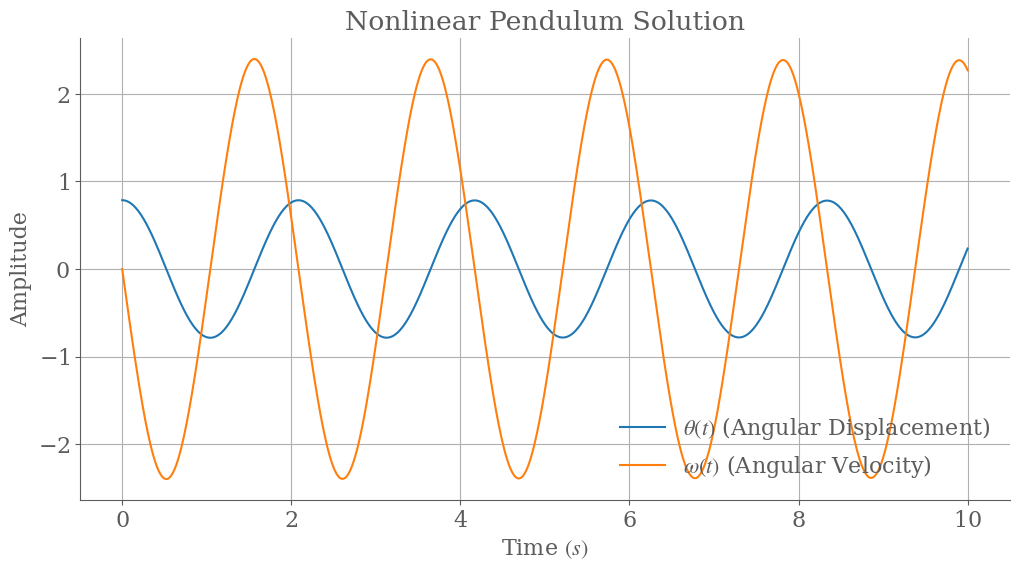

In [3]:
from scipy.integrate import solve_ivp

# Solve the initial value problem using Runge-Kutta 4th order
sol = solve_ivp(pendulum, t_span, y0, t_eval=t_eval, method='RK45')

# We extract the solutions
theta = sol.y[0]
omega = sol.y[1]
t = sol.t

# We graph the results
plt.figure(figsize=(12, 6))
plt.plot(t, theta, label=r'$\theta(t)$ (Angular Displacement)')
plt.plot(t, omega, label=r'$\omega(t)$ (Angular Velocity)')
plt.xlabel(r'Time $(s)$')
plt.ylabel('Amplitude')
plt.legend(loc='best', frameon=False)
plt.title('Nonlinear Pendulum Solution')
plt.grid(True)
plt.show()

In the following, we will consider the numerical solution as the **training data**. Suppose that this **training data** comes from an **angular encoder** (a sensor) in the base of the pendulum, from only one quarter of the time and a low sample rate. To simulate this conditions, we add some gaussian noise, resample and cut the data to $2.5s$. 

Also, we calculate the signal-to-noise ratio $SNR = 10\log_{10} \left(\frac{P_{signal}}{P_{noise}}\right)$, where $P_{signal}$ and $P_{noise}$ are the power of the signal and the noise, respectively, get the amount of distortion in the signal.

We will call the noisy data $\theta_{data}$

SNR: 15.2814 dB


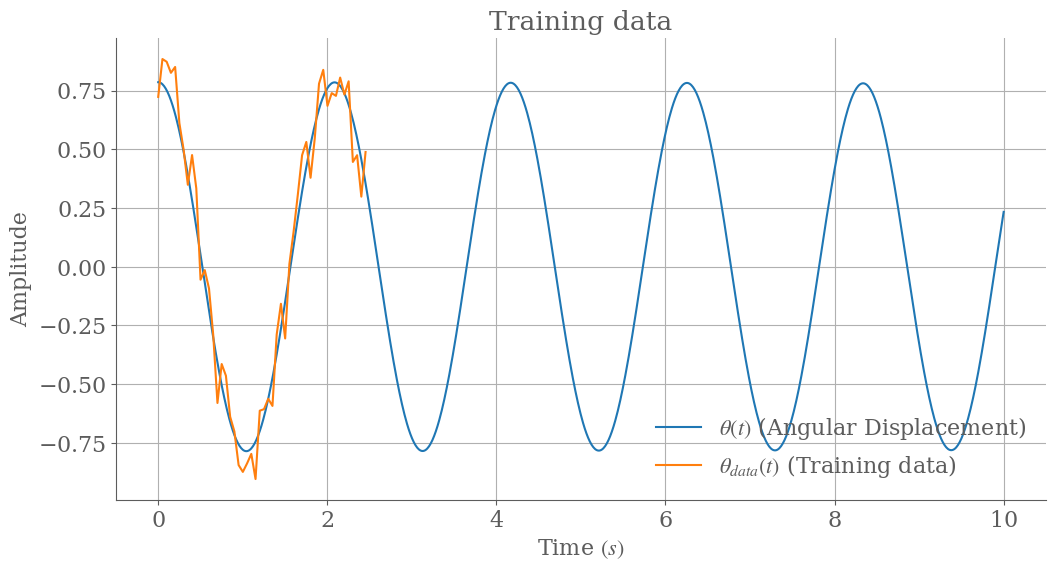

In [4]:
# Add gaussian noise
noise = np.random.normal(0,0.1,theta.shape[0])
theta_data = theta + noise
print(f'SNR: {calculate_snr(theta_data, noise):.4f} dB')

# Resample to 10Hz and cut to 2.5s
resample = 5    # resample to 10Hz 
ctime = int(2.5*100)  # 2.5s times 100Hz

theta_data = theta_data[:ctime:resample]
t_eval = t_eval[:ctime:resample]

# We graph the observed data
plt.figure(figsize=(12, 6))
plt.plot(t, theta, label=r'$\theta(t)$ (Angular Displacement)')
plt.plot(t_eval, theta_data, label=r'$\theta_{data}(t)$ (Training data)')
plt.xlabel(r'Time $(s)$')
plt.ylabel('Amplitude')
plt.legend(loc='lower right', frameon=False)
plt.title('Training data')
plt.grid(True)
plt.show()

## Training the Artificial Neural Network

We train the artificial neural network to directly approximate the solution to the differential equation, i.e.,

$$
\theta_{NN}(t; \Theta) \approx \theta(t)
$$

where $\Theta$ are the free parameters of the ANN, usually called weigths.

### Loss function
To train the ANN, it is mandatory to define the loss function. To this end, we consider the noisy data $\theta_{data}$ and use the mean squared error ($MSE$) over the colocation points (samples over the domain) $\{t_i\}_N$, i.e.,

$$
\mathcal{L}(\Theta) := \lambda_1 MSE(\theta_{NN}(t; \Theta), \theta_{data}) = \frac{\lambda_1}{N}\sum_i (\theta_{NN}(t_i; \Theta) - \theta_{data}(t_i))^2
$$

where $\lambda_1\in\mathbb{R}^+$ is a positive (weigth) number. The training is performed by minimizing the loss function $\mathcal{L}(\Theta)$, i.e.,

$$
\min_{\Theta} \mathcal{L}(\Theta)
$$

Now, we use `PyTorch` and define the neural network, the function loss and, for this task, we will use the ADAM optimizer. Also, we convert the temporal domain and the observations to `torch.tensors`

In [5]:
# Define a loss function (Mean Squared Error) for training the network
loss_func = nn.MSELoss()

# Convert temporal data and observations to tensors
theta_datat = torch.from_numpy(theta_data).float().unsqueeze(-1)
t_evalt = torch.from_numpy(t_eval).float().unsqueeze(-1)

# Define a neural network class with three fully connected layers
class NeuralNetwork(nn.Module):
    
    def __init__(self, hlayers):
        super(NeuralNetwork, self).__init__()
        
        layers = []
        for i in range(len(hlayers[:-2])):
            layers.append(nn.Linear(hlayers[i], hlayers[i+1]))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hlayers[-2], hlayers[-1]))
        
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)
    
def NeuralNetworkLoss(forward_pass, time, theta_data, lambda1 = 1):
    
    theta_nn = forward_pass(time)
    data_loss = loss_func(theta_nn, theta_data)
    
    return lambda1 * data_loss
    
# Create an instance of the neural network
theta_nn = NeuralNetwork([1,10,10,10,1])

# Define an optimizer (Adam) for training the network
optimizer = optim.Adam(theta_nn.parameters(), lr=0.01)

# Initialize a list to store the loss values
loss_values = []

# Start the timer
start_time = time.time()

# Training the neural network
for i in range(20000):
    
    optimizer.zero_grad()   # clear gradients for next train

    # input x and predict based on x
    loss = NeuralNetworkLoss(theta_nn,
                             t_evalt,
                             theta_datat)    # must be (1. nn output, 2. target)
    
    # Append the current loss value to the list
    loss_values.append(loss.item())
    
    if i % 1000 == 0:  # print every 100 iterations
        print(f"Iteration {i}: Loss {loss.item()}")
    
    loss.backward() # compute gradients (backpropagation)
    optimizer.step() # update the ANN weigths

# Stop the timer and calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time} seconds")


Iteration 0: Loss 0.3498382568359375
Iteration 1000: Loss 0.008642890490591526
Iteration 2000: Loss 0.008038817904889584
Iteration 3000: Loss 0.007447694428265095
Iteration 4000: Loss 0.005915531888604164
Iteration 5000: Loss 0.004300874657928944
Iteration 6000: Loss 0.0028387627098709345
Iteration 7000: Loss 0.001847209525294602
Iteration 8000: Loss 0.0011631930246949196
Iteration 9000: Loss 0.0010862223571166396
Iteration 10000: Loss 0.0010456487070769072
Iteration 11000: Loss 0.0010875866282731295
Iteration 12000: Loss 0.0009736521751619875
Iteration 13000: Loss 0.0009709317237138748
Iteration 14000: Loss 0.0009544225176796317
Iteration 15000: Loss 0.0009771148907020688
Iteration 16000: Loss 0.0009388809558004141
Iteration 17000: Loss 0.0009317732765339315
Iteration 18000: Loss 0.000973392860032618
Iteration 19000: Loss 0.0009404968004673719
Training time: 6.477640151977539 seconds


and we plot the results

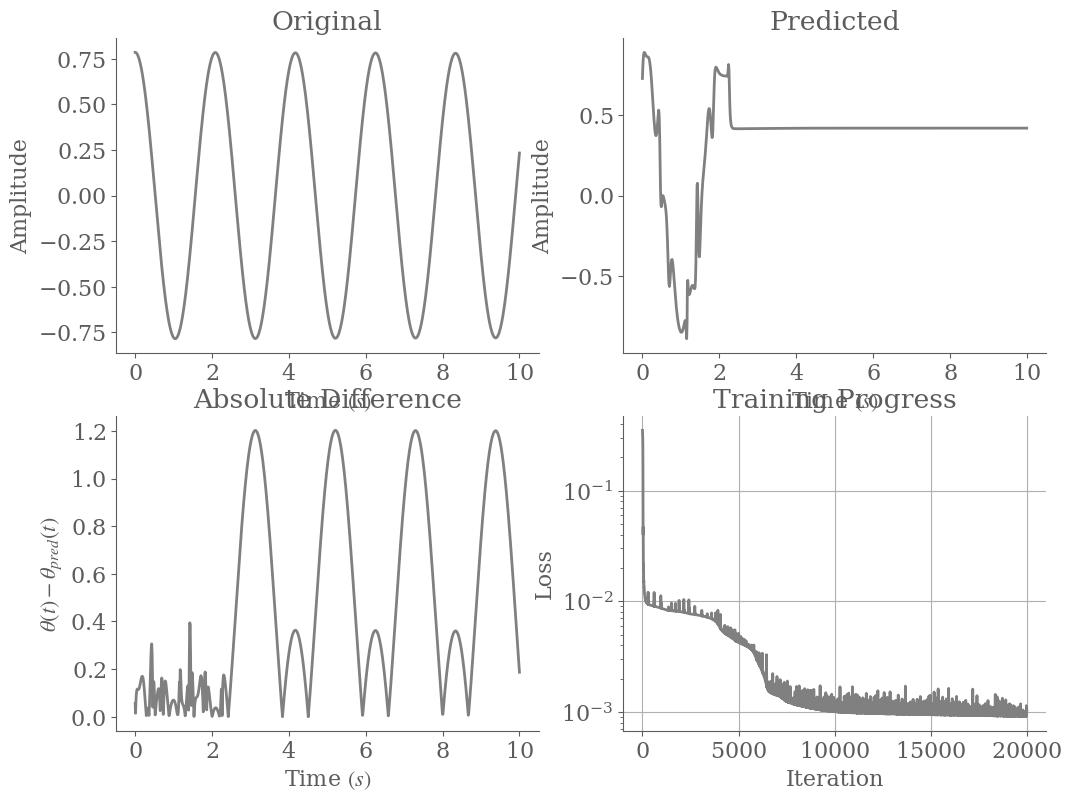

In [6]:
# Convert the NumPy arrays to PyTorch tensors and add an extra dimension
theta_t = torch.from_numpy(theta).float().unsqueeze(-1)  # Convert x data to a PyTorch tensor
t_t = torch.from_numpy(t).float().unsqueeze(-1)  # Convert y data to a PyTorch tensor

theta_pred = theta_nn(t_t)

plot_comparison(t_t, theta_t, theta_pred, loss_values)

Some excercises:
1. try changing lambda to lower or higher values